In [1]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()
olivetti.keys()
X, y = olivetti['data'], olivetti['target']

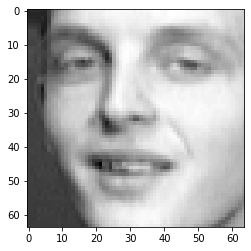

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.imshow(X[398].reshape(64, 64), cmap='gray')

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [51]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
red_X = pca.fit_transform(X_train)
red_X_V = pca.transform(X_val)
red_X_T = pca.transform(X_test)

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
sils = []

for k in range(5, 150, 5):
    kmeans = KMeans(n_clusters=k).fit(red_X)
    inertias.append(kmeans.inertia_)
    sils.append(silhouette_score(X_train, kmeans.labels_))

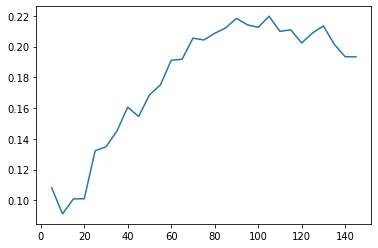

In [18]:
import seaborn as sns

sns.lineplot(x=range(5, 150, 5), y=sils)

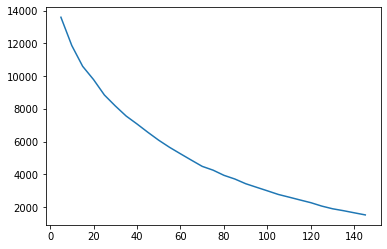

In [23]:
sns.lineplot(x=range(5, 150, 5), y=inertias)

In [28]:
kmeans = KMeans(n_clusters=105).fit(red_X)
pred_labels = kmeans.labels_

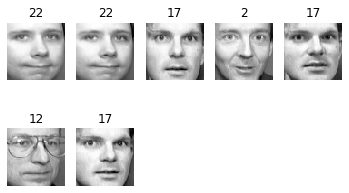

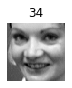

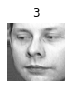

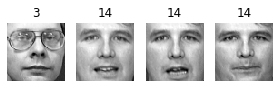

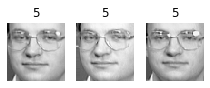

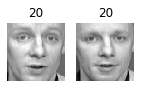

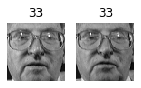

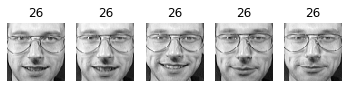

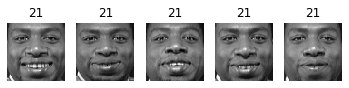

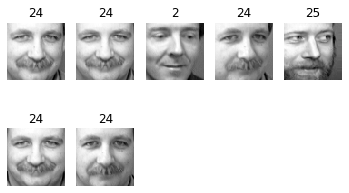

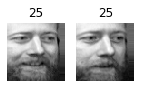

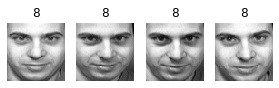

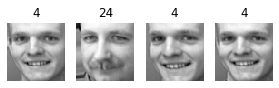

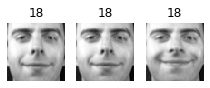

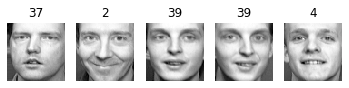

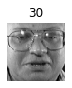

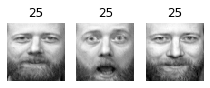

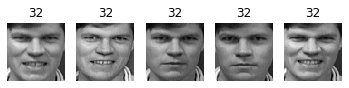

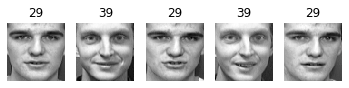

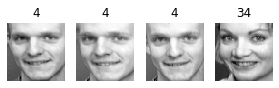

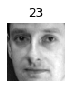

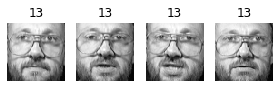

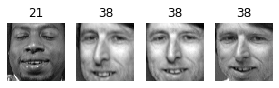

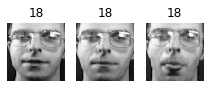

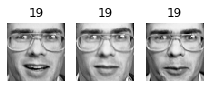

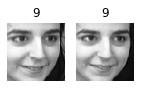

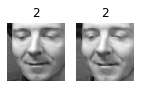

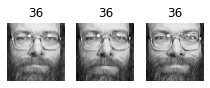

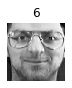

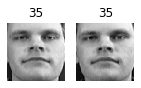

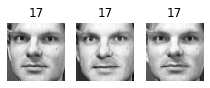

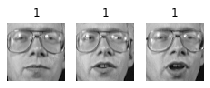

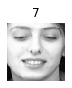

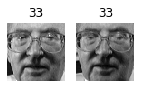

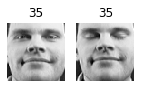

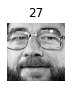

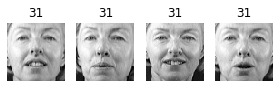

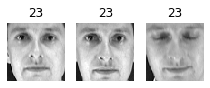

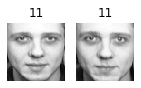

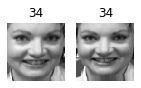

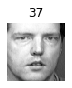

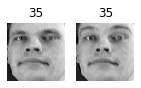

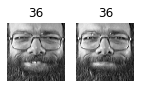

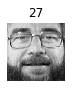

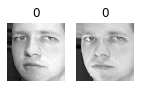

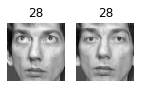

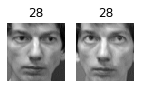

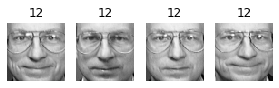

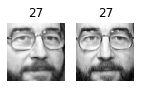

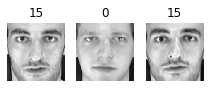

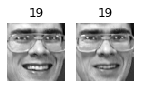

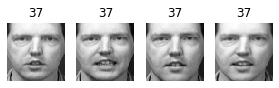

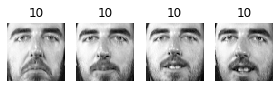

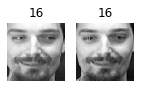

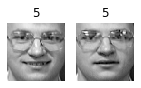

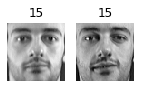

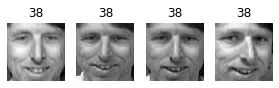

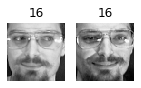

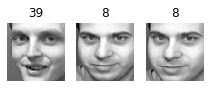

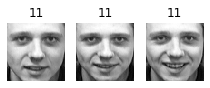

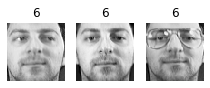

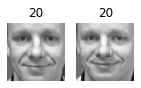

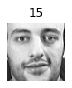

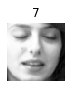

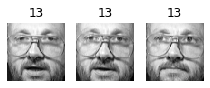

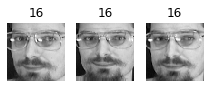

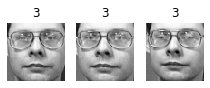

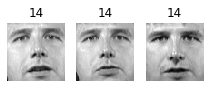

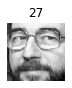

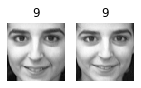

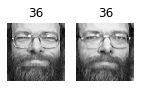

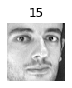

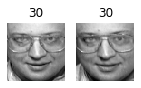

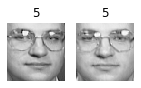

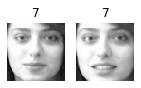

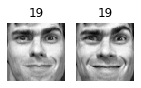

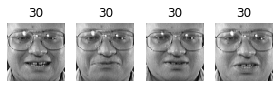

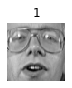

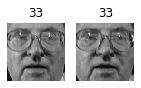

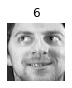

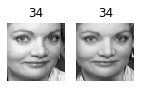

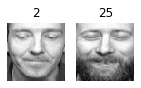

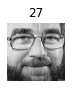

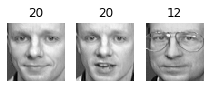

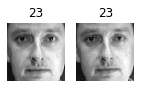

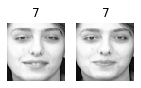

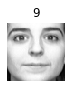

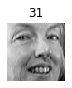

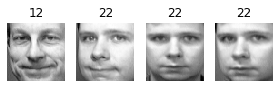

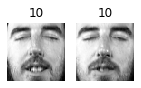

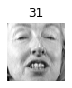

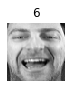

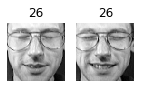

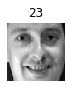

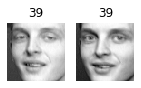

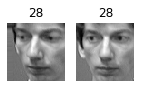

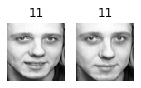

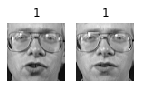

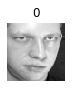

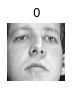

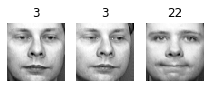

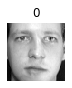

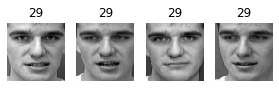

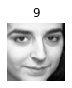

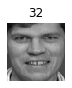

In [41]:
import numpy as np

for c_id in np.unique(pred_labels):
    in_cluster = pred_labels == c_id
    face_in = X_train[in_cluster]
    labels_in = y_train[in_cluster]
    
    n_rows = (len(face_in) - 1) // 6
    plt.figure(figsize=(6, 5 * 1.1))
    
    for cluster, (face, label) in enumerate(zip(face_in, labels_in)):
        plt.subplot(3, 5, cluster+1)
        plt.imshow(face.reshape(64, 64), cmap='gray')
        plt.axis("off")
        plt.title(label)
    plt.show()

# Dimensionality Reduction with K-Means

In [53]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_val, y_val)

Z:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.96875

In [48]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("kmeans", KMeans(n_clusters=120)),
    ("logistic", LogisticRegression())
])

In [55]:
pipe.fit(X_train, y_train)
pipe.score(X_val, y_val)

Z:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.84375

# Gaussian Mixture

In [56]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=420)
y_preds = gm.fit_predict(red_X)

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_preds)

0.015625

In [76]:
n_gen_faces = 20
gen_faces_reduced = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced[0])

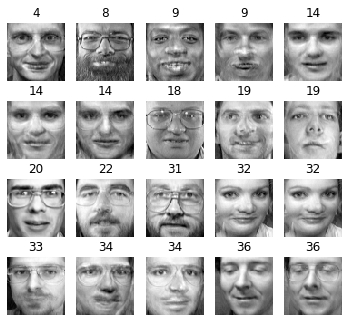

In [84]:
n_rows = (len(gen_faces) - 1) // 6
plt.figure(figsize=(6, 5 * 1.1))

for cluster, (face, label) in enumerate(zip(gen_faces, gen_faces_reduced[1])):
    plt.subplot(4, 5, cluster+1)
    plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.show()

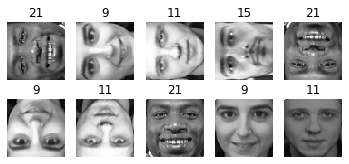

In [86]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

for cluster, (face, label) in enumerate(zip(X_bad_faces, y_bad)):
    plt.subplot(3, 5, cluster+1)
    plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.show()

In [91]:
bad_face_pca = pca.transform(X_bad_faces)
gm.score_samples(bad_face_pca)

array([-13485076.66955077, -40301974.69389413, -47886829.37838865,
       -33347269.17536025, -24365114.56420304, -48921948.15598966,
       -51315678.50953089, -72097784.60737191, -57580726.53965751,
       -56042530.50850804])

In [92]:
gm.score_samples(red_X[:10])

array([ 985.70749205, 1041.68446426, 1055.40381676, 1055.68730791,
       1062.18372542, 1004.72730874, 1086.85025334, 1070.88151163,
       1055.68730878, 1064.62435235])

# PCA Reconstruction Error

In [93]:
def reconstruction_error(pca, X):
    X_pca = pca.transform(X)
    X_recon = pca.inverse_transform(X_pca)
    mse = np.square(X_recon-X).mean(axis=-1)
    return mse

In [100]:
reconstruction_error(pca, X_train).mean()

0.0001906213

In [101]:
reconstruction_error(pca, X_bad_faces).mean()

0.0067953616

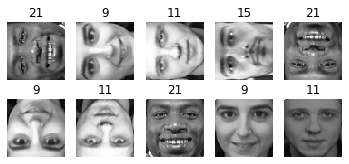

In [102]:
for cluster, (face, label) in enumerate(zip(X_bad_faces, y_bad)):
    plt.subplot(3, 5, cluster+1)
    plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.show()

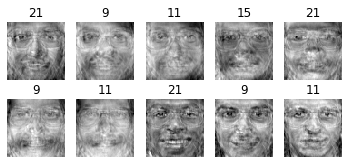

In [103]:
bad_recon = pca.inverse_transform(bad_face_pca)

for cluster, (face, label) in enumerate(zip(bad_recon, y_bad)):
    plt.subplot(3, 5, cluster+1)
    plt.imshow(face.reshape(64, 64), cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.show()